In [18]:
%%capture
#Import Libraries
import numpy as np  
import pandas as pd  
import pandas_datareader as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

In [19]:
#Settings for Monte Carlo asset data, how long, and how many forecasts 
ticker = 'GDP' # ticker
t_intervals = 40 # time steps forecasted into future
iterations = 1000 # amount of simulations

In [20]:
#Acquiring data
data = pd.read_csv('gdp_data_old_1.csv',index_col=0,usecols=['DATE', 'GDP'])
data = data.rename(columns={"Price": ticker}) #.reset_index()

In [21]:
#Preparing log returns from data
log_returns = np.log(1 + data.pct_change())

C:\Users\GM\anaconda3\envs\dev\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


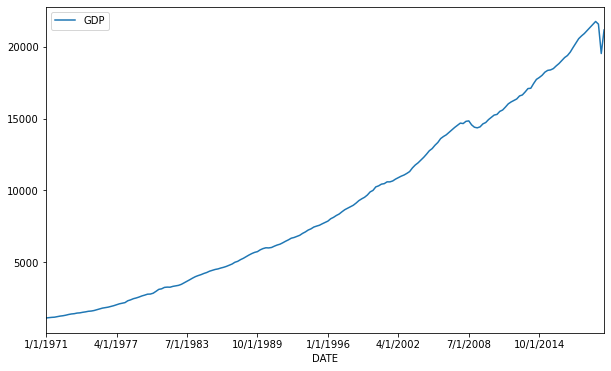

In [22]:
#Plot of asset historical closing price
data.plot(figsize=(10, 6));

C:\Users\GM\anaconda3\envs\dev\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='DATE'>

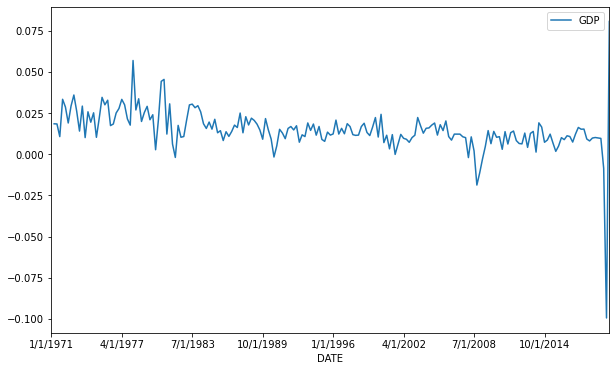

In [23]:
#Plot of log returns
log_returns.plot(figsize = (10, 6))

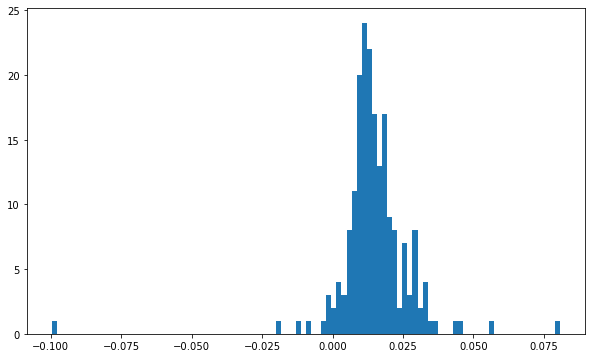

In [24]:
plt.figure(figsize=(10,6))
plt.hist(log_returns, 100) #Note that we run the line plot and histogram separately, not simultaneously.
plt.show()

In [25]:
print(round(np.mean(log_returns*100),2)) # GDP Quarterly Average Return

GDP    1.48
dtype: float64


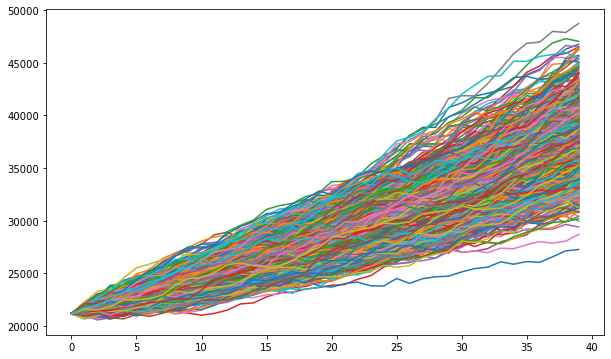

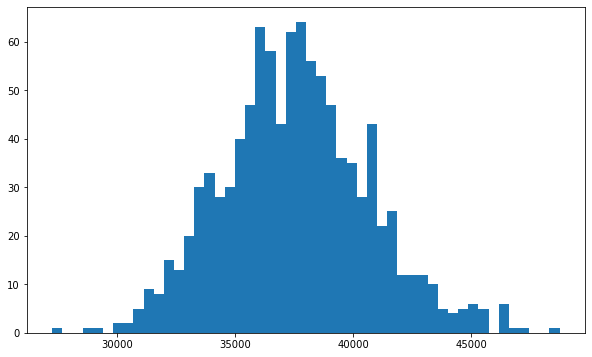

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

#set up empty list to hold our ending values for each simulated price series
result = []

#Setting up drift and random component in relation to asset data
u = log_returns.mean() # Return
var = log_returns.var() #Volatility
drift = u - (0.5 * var)
stdev = log_returns.std()

daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

#Takes last data point as startpoint point for simulation
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

#Applies Monte Carlo simulation in asset
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
    
plt.figure(figsize=(10,6))
plt.plot(price_list)
result.append(price_list[-1])

#show the plot of multiple price series created above
plt.show()

#create histogram of ending stock values for our mutliple simulations
plt.figure(figsize=(10,6))
plt.hist(result,bins=50)
plt.show()

In [111]:
# print("Mean =",round(np.mean(result)))
print(f"Expected future value of US GDP, {t_intervals} quarters in the future: {round(future_GDP,2)}")
print("5% quantile =",round(np.percentile(result,5)))
print("95% quantile =",round(np.percentile(result,95)))

Expected future value of US GDP, 40 quarters in the future: 37571
5% quantile = 32684
95% quantile = 42936


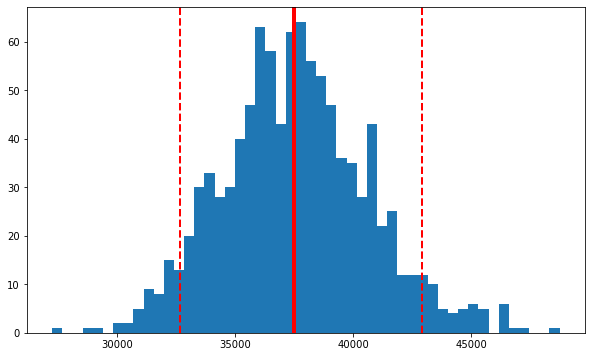

In [108]:
plt.figure(figsize=(10,6))
plt.hist(result,bins=50)
plt.axvline(np.percentile(result,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(result,50), color='r', linestyle='solid', linewidth=4)
plt.axvline(np.percentile(result,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

In [29]:
%%capture
# Import libraries and dependencies

import os
import pandas as pd
import alpaca_trade_api as tradeapi
import seaborn as sns
import numpy as np
import datetime as dt
from pathlib import Path
from MCForecastTools import MCSimulation

In [30]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
 # Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [32]:
 # Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes between now and 5 years ago.
start_date = pd.Timestamp("2004-11-08", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-11-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["SPY","DIA","QQQ","GLD","IEF"]

# Get 5 year's worth of historical price data
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df
# Drop the time component of the date
df_ticker.index = df_ticker.index.date
# Display sample data
df_ticker.head()

DIA                                      GLD                \
              open    high     low   close    volume   open   high    low   
2008-01-02  132.47  132.67  129.82  130.38  14555063  83.56  85.14  83.44   
2008-01-03  130.69  131.27  130.13  130.46   7867911  84.87  85.94  84.60   
2008-01-04  129.57  129.73   98.92   98.94  15489641  85.38  85.55  84.43   
2008-01-07   99.06  128.62   98.08  128.26  22119983  85.24  85.26  84.57   
2008-01-08  128.53  129.00   97.05   97.15  23484347  86.25  87.13  86.16   

                             ...    QQQ                                  \
            close    volume  ...   open   high    low  close     volume   
2008-01-02  84.84  11975400  ...  51.27  51.47  50.13  50.41  149569531   
2008-01-03  85.53   9079600  ...  50.39  50.76  50.15  50.43  104746815   
2008-01-04  85.11   7676100  ...  49.79  49.83  48.25  48.28  193237479   
2008-01-07  84.77   6331500  ...  48.41  48.68  47.43  48.17  220176338   
2008-01-08  86.77   8969400  ...  48.29  48.76  46.97  46.98  236721448   

               SPY                                     
              open    high     low   close     volume  
2008-01-02  146.53  146.99  143.88  144.55  175801806  
2008-01-03  144.92  145.49  144.12  144.46  111357758  
2008-01-04  143.34  143.44  140.92  140.93  195945264  
2008-01-07  141.81  142.23  140.10  141.46  220398905  
2008-01-08  142.10  142.90  138.63  138.81  303249870  

[5 rows x 25 columns]

In [33]:
dia = df_ticker['DIA']
dia

,open,high,low,close,volume
2008-01-02,132.47,132.6700,129.8200,130.38,14555063
2008-01-03,130.69,131.2700,130.1300,130.46,7867911
2008-01-04,129.57,129.7300,98.9200,98.94,15489641
2008-01-07,99.06,128.6200,98.0800,128.26,22119983
2008-01-08,128.53,129.0000,97.0500,97.15,23484347
2008-01-09,97.10,126.8500,96.2100,98.00,27025271
2008-01-10,97.21,128.6500,97.0500,98.67,28192093
2008-01-11,127.51,127.5800,97.0200,97.41,24590512
2008-01-14,98.02,98.5800,97.6300,98.43,9732392
2008-01-15,126.49,126.9100,96.6600,96.72,22624393


In [34]:
dia.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [35]:
# Use the `drop` function to delete the newly created `Age` column
# Use the `drop` function to delete the newly created `Age` column
dia = dia.drop(columns=["low"])
dia = dia.drop(columns=["high"])
dia = dia.drop(columns=["open"])
dia = dia.drop(columns=["volume"])
dia = dia.rename(columns={
    "close": "DIA",
})

dia.head()

,DIA
2008-01-02,130.38
2008-01-03,130.46
2008-01-04,98.94
2008-01-07,128.26
2008-01-08,97.15


In [36]:
qqq = df_ticker['QQQ']
qqq

,open,high,low,close,volume
2008-01-02,51.270,51.4700,50.1300,50.41,149569531
2008-01-03,50.390,50.7600,50.1500,50.43,104746815
2008-01-04,49.790,49.8300,48.2500,48.28,193237479
2008-01-07,48.410,48.6800,47.4300,48.17,220176338
2008-01-08,48.290,48.7600,46.9700,46.98,236721448
2008-01-09,47.090,47.9600,46.4600,47.94,244459758
2008-01-10,47.410,48.4100,47.2900,48.01,237095761
2008-01-11,47.720,47.7700,46.7000,47.05,201430700
2008-01-14,47.690,48.0100,47.3100,47.92,149245841
2008-01-15,47.380,47.5200,46.3500,46.58,209225406


In [37]:
# Use the `drop` function to delete the newly created `Age` column
# Use the `drop` function to delete the newly created `Age` column
qqq = qqq.drop(columns=["low"])
qqq = qqq.drop(columns=["high"])
qqq = qqq.drop(columns=["open"])
qqq = qqq.drop(columns=["volume"])
qqq = qqq.rename(columns={
    "close": "QQQ",
})
qqq.head()

,QQQ
2008-01-02,50.41
2008-01-03,50.43
2008-01-04,48.28
2008-01-07,48.17
2008-01-08,46.98


In [38]:
gld = df_ticker['GLD']

# Use the `drop` function to delete the newly created `Age` column
# Use the `drop` function to delete the newly created `Age` column
gld = gld.drop(columns=["low"])
gld = gld.drop(columns=["high"])
gld = gld.drop(columns=["open"])
gld = gld.drop(columns=["volume"])
gld = gld.rename(columns={
    "close": "GLD",
})
gld.head()

,GLD
2008-01-02,84.84
2008-01-03,85.53
2008-01-04,85.11
2008-01-07,84.77
2008-01-08,86.77


In [39]:
ief = df_ticker['IEF']
ief
ief = ief.drop(columns=["low"])
ief = ief.drop(columns=["high"])
ief = ief.drop(columns=["open"])
ief = ief.drop(columns=["volume"])
ief = ief.rename(columns={
    "close": "IEF",
})
ief.head()

,IEF
2008-01-02,87.65
2008-01-03,87.77
2008-01-04,87.99
2008-01-07,88.23
2008-01-08,88.39


In [40]:
spy = df_ticker['SPY']
spy
# Use the `drop` function to delete the newly created `Age` column
# Use the `drop` function to delete the newly created `Age` column
spy = spy.drop(columns=["low"])
spy = spy.drop(columns=["high"])
spy = spy.drop(columns=["open"])
spy = spy.drop(columns=["volume"])
spy = spy.rename(columns={
    "close": "SPY",
})
spy.head()

,SPY
2008-01-02,144.55
2008-01-03,144.46
2008-01-04,140.93
2008-01-07,141.46
2008-01-08,138.81


In [41]:
combined_df = pd.concat([spy, gld, qqq, ief, dia], axis="columns", join="inner")
combined_df

,SPY,GLD,QQQ,IEF,DIA
2008-01-02,144.550,84.84,50.41,87.650,130.38
2008-01-03,144.460,85.53,50.43,87.770,130.46
2008-01-04,140.930,85.11,48.28,87.990,98.94
2008-01-07,141.460,84.77,48.17,88.230,128.26
2008-01-08,138.810,86.77,46.98,88.390,97.15
2008-01-09,140.780,86.54,47.94,88.250,98.00
2008-01-10,141.800,88.24,48.01,87.990,98.67
2008-01-11,140.010,88.56,47.05,88.570,97.41
2008-01-14,141.460,89.54,47.92,88.610,98.43
2008-01-15,137.950,88.00,46.58,89.200,96.72


In [42]:
# Calculate the correlation between each column
correlation = combined_df.corr()
correlation

,SPY,GLD,QQQ,IEF,DIA
SPY,1.000000,0.274478,0.973994,0.714571,0.987969
GLD,0.274478,1.000000,0.354761,0.628643,0.273540
QQQ,0.973994,0.354761,1.000000,0.737030,0.959517
IEF,0.714571,0.628643,0.737030,1.000000,0.679838
DIA,0.987969,0.273540,0.959517,0.679838,1.000000


<AxesSubplot:>

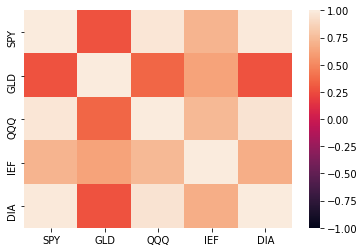

In [43]:
# Use the `heatmap` function from the Seaborn library to visualize correlations
sns.heatmap(correlation, vmin=-1, vmax=1)

In [44]:
# file_path = Path("Project/gdp_data.csv")
file_path = Path("gdp_data.csv")
gdp_data = pd.read_csv(
    file_path, index_col="DATE", infer_datetime_format=True, parse_dates=True)
gdp_data

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
1948-04-01,272.567
1948-07-01,279.196
1948-10-01,280.366
1949-01-01,275.034


In [45]:
combined_df_wgdp = pd.concat([gdp_data, combined_df], axis="columns", join="inner")
combined_df_wgdp

,GDP,SPY,GLD,QQQ,IEF,DIA
2008-04-01,14805.611,136.8100,86.8800,45.58,90.580,126.42
2008-07-01,14835.187,128.3700,92.6600,45.83,87.470,113.77
2008-10-01,14559.543,115.9900,85.9500,38.49,89.250,108.36
2009-04-01,14352.850,81.0300,90.9800,30.78,96.550,62.07
2009-07-01,14420.312,92.3400,92.3740,33.12,90.330,85.05
2009-10-01,14628.021,102.9900,97.9120,41.00,92.810,77.27
2010-04-01,14926.098,117.8100,110.2490,43.98,89.040,109.27
2010-07-01,15079.917,102.7900,117.0400,42.58,95.340,97.34
2010-10-01,15240.843,114.6299,128.9300,49.02,98.830,108.31
2011-04-01,15496.189,133.1600,139.1900,57.45,92.940,123.45


In [57]:
%%capture
# import libraries
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [58]:
# file_path = Path("Market_Data_GM.csv")
# mkt_data = pd.read_csv(file_path, index_col="Date")
# file_path = Path("gdp_data_new_k.csv")
# gdp_data = pd.read_csv(file_path, index_col="DATE")

In [104]:
future_GDP = round(np.mean(result))
print(f"Expected future value of US GDP, {t_intervals} quarters in the future: {round(future_GDP,2)}")

Expected future value of US GDP, 40 quarters in the future: 37571


In [87]:
# mkt_data.head()
combined_df_wgdp.head()

,GDP,SPY,GLD,QQQ,IEF,DIA
2008-04-01,14805.611,136.81,86.880,45.58,90.58,126.42
2008-07-01,14835.187,128.37,92.660,45.83,87.47,113.77
2008-10-01,14559.543,115.99,85.950,38.49,89.25,108.36
2009-04-01,14352.850,81.03,90.980,30.78,96.55,62.07
2009-07-01,14420.312,92.34,92.374,33.12,90.33,85.05


In [88]:
# concatenate GDP with Indices

# joined_data = pd.concat([mkt_data, gdp_data], axis="columns", join="inner")
# joined_data.tail()

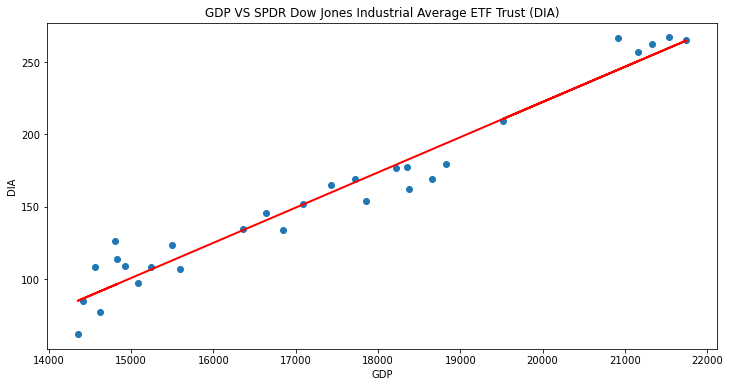

In [89]:
# GDP VS DJIA

model = smf.ols('DIA ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data

plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['DIA'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('DIA')
plt.title('GDP VS SPDR Dow Jones Industrial Average ETF Trust (DIA)')
plt.show()

In [90]:
from scipy import stats

x = combined_df_wgdp['GDP']
y = combined_df_wgdp['DIA']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.024347    intercept: -264.468478
R-squared: 0.952206


In [91]:
future_DJIA = intercept + slope * future_GDP
print(f"Expected future value of the SPDR Dow Jones Industrial Average ETF Trust (DIA): {round(future_DJIA,2)}")

Expected future value of the SPDR Dow Jones Industrial Average ETF Trust (DIA): 650.26


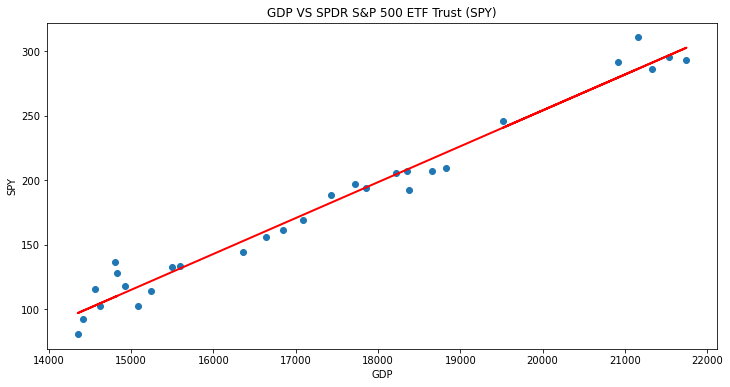

In [92]:
# GDP VS S&P 500

model = smf.ols('SPY ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data

plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['SPY'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('SPY')
plt.title('GDP VS SPDR S&P 500 ETF Trust (SPY)')
plt.show()

In [93]:
from scipy import stats

x = combined_df_wgdp['GDP']
y = combined_df_wgdp['SPY']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.027786    intercept: -301.616717
R-squared: 0.973017


In [94]:
future_SP_500 = intercept + slope * future_GDP
print(f"Expected future value of the SPDR S&P 500 ETF Trust (SPY): {round(future_SP_500,2)}")

Expected future value of the SPDR S&P 500 ETF Trust (SPY): 742.34


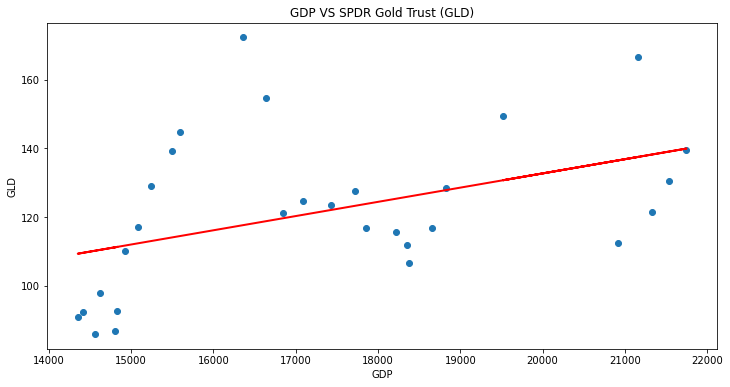

In [95]:
# GDP VS Gold

model = smf.ols('GLD ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data

plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['GLD'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('GLD')
plt.title('GDP VS SPDR Gold Trust (GLD)')
plt.show()

In [96]:
from scipy import stats

x = combined_df_wgdp['GDP']
y = combined_df_wgdp['GLD']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.004142    intercept: 49.874575
R-squared: 0.195046


In [97]:
future_Gold = intercept + slope * future_GDP
print(f"Expected future value of the SPDR Gold Trust (GLD): {round(future_Gold,2)}")

Expected future value of the SPDR Gold Trust (GLD): 205.5


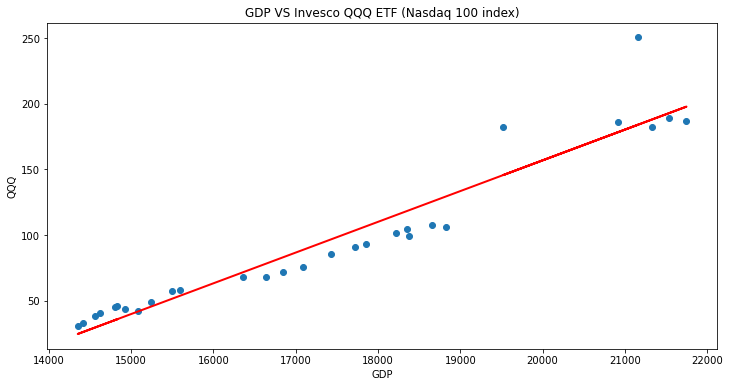

In [98]:
# GDP VS NASDAQ

model = smf.ols('QQQ ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data

plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['QQQ'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('QQQ')
plt.title('GDP VS Invesco QQQ ETF (Nasdaq 100 index)')
plt.show()

In [99]:
from scipy import stats

x = combined_df_wgdp['GDP']
y = combined_df_wgdp['QQQ']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.023394    intercept: -310.943366
R-squared: 0.907512


In [100]:
future_NASDAQ = intercept + slope * future_GDP
print(f"Expected future value of the Invesco QQQ ETF (Nasdaq 100 index): {round(future_NASDAQ,2)}")

Expected future value of the Invesco QQQ ETF (Nasdaq 100 index): 567.99


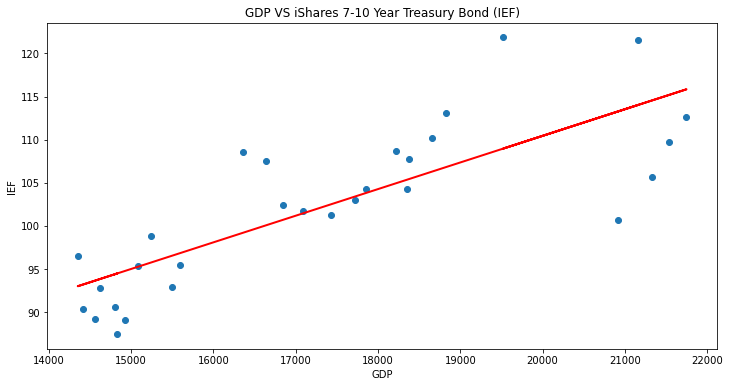

In [101]:
# GDP VS 10 Year UST

model = smf.ols('IEF ~ GDP', data=combined_df_wgdp)
model = model.fit()

sales_pred = model.predict()

# Plot regression against actual data

plt.figure(figsize=(12, 6))
plt.plot(combined_df_wgdp['GDP'], combined_df_wgdp['IEF'], 'o')       # scatter plot showing actual data
plt.plot(combined_df_wgdp['GDP'], sales_pred, 'r', linewidth=2)   # regression line
plt.xlabel('GDP')
plt.ylabel('IEF')
plt.title('GDP VS iShares 7-10 Year Treasury Bond (IEF)')
plt.show()

In [102]:
from scipy import stats

x = combined_df_wgdp['GDP']
y = combined_df_wgdp['IEF']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.003088    intercept: 48.684453
R-squared: 0.634903


In [103]:
future_10UST = intercept + slope * future_GDP
print(f"Expected future value of the iShares 7-10 Year Treasury Bond (IEF): {round(future_10UST,2)}")

Expected future value of the iShares 7-10 Year Treasury Bond (IEF): 164.7
